## Evaluation

In [3]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw


In [4]:
sys.path.append('./SD_LSTM/')
sys.path.append('./LSTM_TF/')
sys.path.append('./VANILLA_VAE/')
sys.path.append('./SD_VAE/')

from sd_vae_sampler import SDVAESampler
from model_sd_vae import SDVAE
from sd_lstm_sampler import SDLSTMSampler
from sd_lstm_utils import load_model as load_sd_lstm_model

from benchmark_vanilla_vae import VanillaVAEHarness

from model_vanilla_vae import VanillaMolVAE
from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

In [5]:
sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [6]:
# Clear modules cache

del sys.modules['benchmark_vanilla_vae']

import importlib
importlib.invalidate_caches()
from benchmark_vanilla_vae import VanillaVAEHarness



del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()
from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

### Load Models

In [5]:
# Load SD-LSTM Model
sd_lstm_model_path = "models/SD_LSTM_QM9_MASKED_CROSS_ENTROPY_TOKENS/"
sd_lstm_weights_fname = "SD_LSTM_dark-hall-89_Epoch_37_Vl_0.199.pt"
sd_lstm_definition_fname = "SD_LSTM_dark-hall-89_Epoch_37_Vl_0.199.json"


sd_lstm_sampler = SDLSTMSampler(device = 'cpu', rules_dict_size = 80, batch_size=64)
sd_lstm_model = load_sd_lstm_model(
            model_definition= os.path.join(sd_lstm_model_path, sd_lstm_definition_fname),
            model_weights = os.path.join(sd_lstm_model_path, sd_lstm_weights_fname),
            device = 'cpu',
            )

with open(os.path.join(sd_lstm_model_path, sd_lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

sd_lstm_mpar = model_params['property_names']
print(f'SD-LSTM Conditioned on Following Props: {sd_lstm_mpar}')

SD-LSTM Conditioned on Following Props: ['LogP']


In [43]:
# Load LSTM Model
'''
lstm_model_path = "models/LSTM_QM9/batch_size_64_2"
lstm_weights_fname = "LSTM_20_1.190.pt"
lstm_definition_fname = "LSTM_20_1.190.json"
'''

lstm_model_path = "models/LSTM_TF_03/"
lstm_weights_fname = 'LSTM_12_1.180.pt'
lstm_definition_fname = 'LSTM_12_1.180.json'


lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_model = load_rnn_model(
            model_definition= os.path.join(lstm_model_path, lstm_definition_fname),
            model_weights = os.path.join(lstm_model_path, lstm_weights_fname),
            device = 'cpu',
            )
    
with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

lstm_mpar = model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {lstm_mpar}')

cLSTM Conditioned on Following Props: ['LogP']


In [32]:
# Load Vanilla VAE Model

# model_weights = 'models/VANILLA_VAE_QM9/SD_LSTM_calm-unit-75_Epoch_19_Vl_0.437.pt'
# model_definit = 'models/VANILLA_VAE_QM9/SD_LSTM_calm-unit-75_Epoch_19_Vl_0.437.json'

# model_weights = 'models/EXPLICIT_VANILLA_VAE/SD_LSTM_throbbing-unit-04_Epoch_99_Vl_0.440.pt'
# model_definit = 'models/EXPLICIT_VANILLA_VAE/SD_LSTM_throbbing-unit-04_Epoch_99_Vl_0.440.json'

# model_weights = 'models/VANILLA_VAE_QM9_3_Best/SD_LSTM_patient-star-05_Epoch_283_Vl_0.082.pt'
# model_definit = 'models/VANILLA_VAE_QM9_3_Best/SD_LSTM_patient-star-05_Epoch_283_Vl_0.082.json'

model_weights = './models/LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_broad-firefly-18_Epoch_239_Vl_0.097.pt'
model_definit = './models/LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_broad-firefly-18_Epoch_239_Vl_0.097.json'

vae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')


vae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
vae_model = vae_model.to('cpu')
vae_model.device = 'cpu'
vae_model.encoder.device = 'cpu'
vae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [1]:
# Load SD VAE Model
model_weights = 'models/SD_VAE_BEST/SD_LSTM_black-night-68_Epoch_65_Vl_0.041.pt'
model_definit = 'models/SD_VAE_BEST/SD_LSTM_black-night-68_Epoch_65_Vl_0.041.json'

sd_vae_model = load_model(model_class=SDVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

sd_vae_model = sd_vae_model.to('cpu')
sd_vae_model.device = 'cpu'
sd_vae_model.encoder.device = 'cpu'
sd_vae_model.state_decoder.device = 'cpu'

sd_vae_sampler = SDVAESampler(batch_size=64, device='cpu')

NameError: name 'load_model' is not defined

In [8]:
# Regularized Vanilla VAE
# model_weights = 'models/REG_VAE_MULTI/SD_REG_VANILLA_VAE_calm-smoke-50_Epoch_154_Vl_0.145.pt'
# model_definit = 'models/REG_VAE_MULTI/SD_REG_VANILLA_VAE_calm-smoke-50_Epoch_154_Vl_0.145.json'

# model_weights = 'models/REG_SAMPLE_BEST/SD_REG_VANILLA_VAE_shy-voice-55_Epoch_172_Vl_0.236.pt'
# model_defenit = 'models/REG_SAMPLE_BEST/SD_REG_VANILLA_VAE_shy-voice-55_Epoch_172_Vl_0.236.json'

# model_weights = 'models/REG_VAE_BEST/SD_REG_VANILLA_VAE_mute-brook-70_Epoch_261_Vl_0.161.pt'
# model_defenit = 'models/REG_VAE_BEST/SD_REG_VANILLA_VAE_mute-brook-70_Epoch_261_Vl_0.161.json'

# model_weights = 'models/REG_VAE_BEST/SD_REG_VANILLA_VAE_steep-dust-67_Epoch_175_Vl_0.189.pt'
# model_definit = 'models/REG_VAE_BEST/SD_REG_VANILLA_VAE_steep-dust-67_Epoch_175_Vl_0.189.json'

# model_weights = 'models/REG_VAE_5_LATENT_ARGMAX_LSTM/SD_REG_VANILLA_VAE_weathered-rice-04_Epoch_97_Vl_0.166.pt'
# model_definit = 'models/REG_VAE_5_LATENT_ARGMAX_LSTM/SD_REG_VANILLA_VAE_weathered-rice-04_Epoch_97_Vl_0.166.json'

# model_weights = 'models/REG_VAE_ARGMAX_MULTI/SD_REG_VANILLA_VAE_weathered-rice-04_Epoch_269_Vl_0.160.pt'
# model_definit = 'models/REG_VAE_ARGMAX_MULTI/SD_REG_VANILLA_VAE_weathered-rice-04_Epoch_269_Vl_0.160.json'


reg_vae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')
reg_vae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
reg_vae_model = reg_vae_model.to('cpu')
reg_vae_model.device = 'cpu'
reg_vae_model.encoder.device = 'cpu'
reg_vae_model.state_decoder.device = 'cpu'

TypeError: VanillaMolVAE.__init__() got an unexpected keyword argument 'decision_dim'

In [11]:
# Load Explicit Vanilla VAE Model

# TODO: FIX NAME CLASHES
file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

# Now you can use the module
# explicit_sampler = module.VanillaVAEHarness
explicit_model_class = module.VanillaMolVAE


file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

# Now you can use the module
# explicit_sampler = module.VanillaVAEHarness
harness_class = module.VanillaVAEHarness


model_weights = 'models/EXPLICIT_VANILLA_VAE/SD_LSTM_throbbing-unit-04_Epoch_99_Vl_0.440.pt'
model_definit = 'models/EXPLICIT_VANILLA_VAE/SD_LSTM_throbbing-unit-04_Epoch_99_Vl_0.440.json'

# model_weights = 'models/EXPLICIT_VANILLA_VAE_TF_03/SD_LSTM_odd-sunset-14_Epoch_31_Vl_0.351.pt'
# model_definit = 'models/EXPLICIT_VANILLA_VAE_TF_03/SD_LSTM_odd-sunset-14_Epoch_31_Vl_0.351.json'

# model_weights = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_square-mouse-81_Epoch_100_Vl_0.250.pt'
# model_definit = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_square-mouse-81_Epoch_100_Vl_0.250.json'


explicit_vae_sampler = harness_class(batch_size=64, device='cpu')

explicit_vae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')
# ugly hack

# explicit_vae_model = explicit_vae_model.to('cpu')
# explicit_vae_model.device = 'cpu'
# explicit_vae_model.encoder.device = 'cpu'
# explicit_vae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [21]:
vae_sampler.sample(model=vae_model, properties=torch.Tensor([[-3.0], [-3.5]]))  # max_seq_len=101)

['N[[HC)]][C)]CCOOC1Oo)H1C-', 'O[=(=[[C]=1C=))=)(OOOO12[]C2]]-']

# Dataset

In [22]:
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


### Target Property Distributions

In [23]:
prop_names = ['LogP']

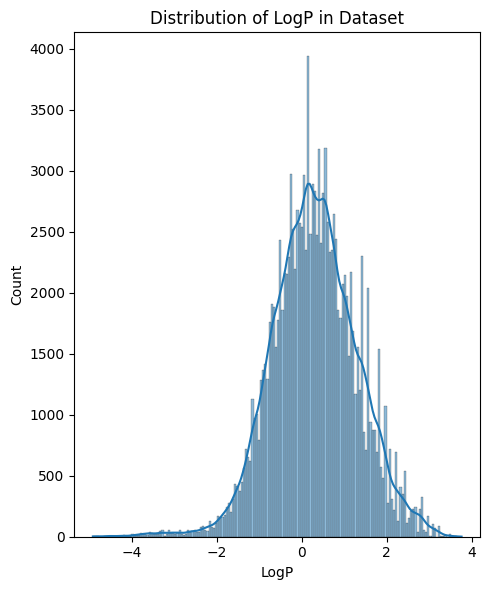

In [8]:
# Distribution of property scores in dataset
plt.figure(figsize=(len(prop_names) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(prop_names):
    plt.subplot(1, len(prop_names), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(qmds[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column} in Dataset')

plt.tight_layout()
plt.show()

# Reconstruction Performance for VAE-based models

In [24]:
from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()

from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9


In [17]:
benchmark_reconstruction_QM9(sd_vae_model, sd_vae_sampler, test_smiles, test_props)

NameError: name 'sd_vae_model' is not defined

In [19]:
benchmark_reconstruction_QM9(vae_model, vae_sampler, test_smiles, test_props, random=True)

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:29<00:00,  1.75it/s]

Accuracy: 0.8838
Junk PCT: 0.0


(0.8838, 0.0)

In [49]:
benchmark_reconstruction_QM9(reg_vae_model, reg_vae_sampler, test_smiles, test_props, random=False)

  0%|          | 0/157 [00:00<?, ?it/s]

/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:22<00:00,  1.90it/s]

Accuracy: 0.6095
Junk PCT: 0.0


(0.6095, 0.0)

In [13]:
benchmark_reconstruction_QM9(explicit_vae_model, explicit_vae_sampler, test_smiles, test_props, random=False)

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:11<00:00,  2.18it/s]

Accuracy: 0.0454
Junk PCT: 0.0


(0.0454, 0.0)

# Compute Performance Metrics

In [25]:
def return_valid_smiles(smiles_list):
    '''
    return smiles list with invalid smiles removed
    '''
    valid = []
    
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                valid.append(smi)
        except:
            pass
    return valid

## Global Sample Uniform Prop Vals

In [26]:
# Load QM9 Test Smiles
'''
n_samples = 1000
property_val_range = [-3, 3]

targets = np.random.uniform(low=property_val_range[0], high=property_val_range[1], size=n_samples)
targets = torch.Tensor([[a] for a in targets])

target_props = [float(a[0]) for a in targets]
'''

target_props = test_props
targets = torch.Tensor( [[a] for a in target_props])
num_to_sample = len(target_props)

In [27]:
print('Sampling SD_LSTM Model with Random Uniform Targets')
sd_lstm_global_sample_smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=100)
assert(len(sd_lstm_global_sample_smiles) == num_to_sample)

Sampling SD_LSTM Model with Random Uniform Targets


NameError: name 'sd_lstm_sampler' is not defined

In [28]:
#TODO: RANDOM SAMPLING OR NOT???

print('Sampling LSTM Model with Random Uniform Targets')
lstm_global_sample_smiles = lstm_sampler.sample(model=lstm_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=100, random_sample=True)
assert(len(lstm_global_sample_smiles) == num_to_sample)

Sampling LSTM Model with Random Uniform Targets


NameError: name 'lstm_sampler' is not defined

In [31]:
print('Sampling VAE Model with Random Uniform Targets')
vae_global_sample_smiles = vae_sampler.sample(model = vae_model, properties=targets) # ,  max_seq_len=101)
assert(len(vae_global_sample_smiles) == num_to_sample)

Sampling VAE Model with Random Uniform Targets


/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/benchmark_vanilla_vae.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


In [30]:
print('Sampling SD VAE Model with Random Uniform Targets')
sd_vae_global_sample_smiles = sd_vae_sampler.sample(model = sd_vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=99)
assert(len(sd_vae_global_sample_smiles) == num_to_sample)

Sampling SD VAE Model with Random Uniform Targets


  0%|          | 0/16 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./SD_VAE/model_sd_vae.py:230: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
/home/chrome/Code/MolGen/my_code/./SD_VAE/sd_vae_sampler.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raw_logits = torch.tensor(model.state_decoder(latent_points, properties)) # .permute(1, 0, 2)
 75%|███████▌  | 12/16 [00:04<00:01,  2.43it/s]


KeyboardInterrupt: 

In [18]:
print('Sampling Regularized Vanilla VAE Model with Random Uniform Targets')
reg_vae_global_sample_smiles = reg_vae_sampler.sample(model = reg_vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=101, random=False)
assert(len(reg_vae_global_sample_smiles) == num_to_sample)


Sampling Regularized Vanilla VAE Model with Random Uniform Targets


NameError: name 'reg_vae_sampler' is not defined

In [43]:
print('Sampling Regularized Vanilla VAE Model with Random Uniform Targets')
explicit_vae_global_sample_smiles = explicit_vae_sampler.sample(model = explicit_vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=101, random=True)
assert(len(explicit_vae_global_sample_smiles) == num_to_sample)

Sampling Regularized Vanilla VAE Model with Random Uniform Targets


  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:17<00:00,  2.04it/s]


In [21]:
# lstm_global_properties = props_from_smiles(lstm_global_sample_smiles)
# sd_lstm_global_properties = props_from_smiles(sd_lstm_global_sample_smiles)
# vae_global_properties = props_from_smiles(vae_global_sample_smiles)
# sd_vae_global_properties = props_from_smiles(sd_vae_global_sample_smiles)
# reg_vae_global_properties = props_from_smiles(reg_vae_global_sample_smiles)
# explicit_vae_global_properties = props_from_smiles(explicit_vae_global_sample_smiles)

100%|██████████| 10000/10000 [00:01<00:00, 8633.38it/s]


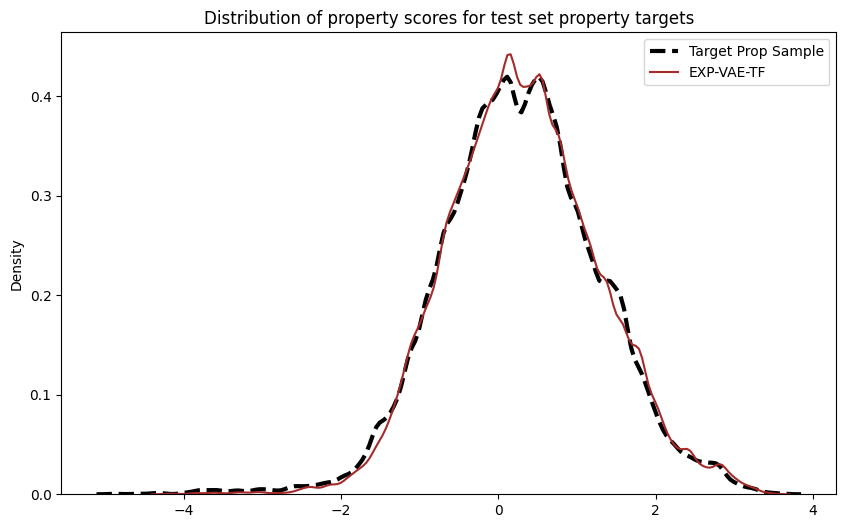

In [22]:
plt.figure(figsize=(10, 6))

sns.kdeplot(target_props, color="black", label='Target Prop Sample', bw_adjust=0.5, linestyle="--", linewidth=3 )
# sns.kdeplot(lstm_global_properties, color="blue", label='LSTM', bw_adjust=0.5)
# sns.kdeplot(sd_lstm_global_properties, color="purple", label='SD-LSTM', bw_adjust=0.5)
# sns.kdeplot(vae_global_properties, color="red", label='VAE', bw_adjust=0.5)
# sns.kdeplot(sd_vae_global_properties, color="orange", label='SD-VAE', bw_adjust=0.5)
# sns.kdeplot(reg_vae_global_properties, color = "brown", label='REG-VAE', bw_adjust=0.5)
sns.kdeplot(explicit_vae_global_properties, color = "brown", label='EXP-VAE-TF', bw_adjust=0.5)
# pval0 = property_val_range[0]
# pval1 = property_val_range[1]

plt.title(f'Distribution of property scores for test set property targets')# {pval0} : {pval1})')
plt.legend()
plt.show()

## Sample Metrics
Validity, uniqeness, novelty

In [24]:
# lstm_metrics = amina_metrics(lstm_global_sample_smiles, train_smiles)
# sd_lstm_metrics = amina_metrics(sd_lstm_global_sample_smiles, train_smiles)
# vae_metrics = amina_metrics(vae_global_sample_smiles, train_smiles)
# sd_vae_metrics = amina_metrics(sd_vae_global_sample_smiles, train_smiles)
# reg_vae_metrics = amina_metrics(reg_vae_global_sample_smiles, train_smiles)
exp_vae_metrics = amina_metrics(explicit_vae_global_sample_smiles, train_smiles)

In [26]:
exp_vae_metrics


(0.8419, 0.9704240408599596, 0.4325581395348837)

In [27]:
exp_vae_absolute_metrics = absolute_metrics(explicit_vae_global_sample_smiles, train_smiles)

In [28]:
exp_vae_absolute_metrics

(0.8419, 0.817, 0.3534)

In [29]:
models = ['LSTM', 'SD-LSTM', 'VAE', 'SD-VAE']
metrics = ['Validity', 'Uniqueness', 'Novelty']
data = {
    'Validity': [lstm_metrics[0], sd_lstm_metrics[0], vae_metrics[0], sd_vae_metrics[0]],
    'Uniqueness': [lstm_metrics[1], sd_lstm_metrics[1], vae_metrics[1], sd_vae_metrics[1]],
    'Novelty': [lstm_metrics[2], sd_lstm_metrics[2], vae_metrics[2], sd_vae_metrics[2]]
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=['blue', 'purple', 'red', 'orange'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

NameError: name 'lstm_metrics' is not defined

## Property Metrics

In [30]:
# lstm_p_metrics = property_metrics(lstm_global_sample_smiles, targets, prop_names = ['LogP'])
# sd_lstm_p_metrics = property_metrics(sd_lstm_global_sample_smiles, targets, prop_names = ['LogP'])
# vae_p_metrics = property_metrics(vae_global_sample_smiles, targets, prop_names = ['LogP'])
# sd_vae_p_metrics = property_metrics(sd_vae_global_sample_smiles, targets, prop_names = ['LogP'])
# reg_vae_p_metrics = property_metrics(reg_vae_global_sample_smiles, targets, prop_names = ['LogP'])
exp_vae_p_metrics = property_metrics(explicit_vae_global_sample_smiles, targets, prop_names = ['LogP'])


In [31]:
exp_vae_p_metrics

([0.9613077363954737], [tensor(0.3388)])

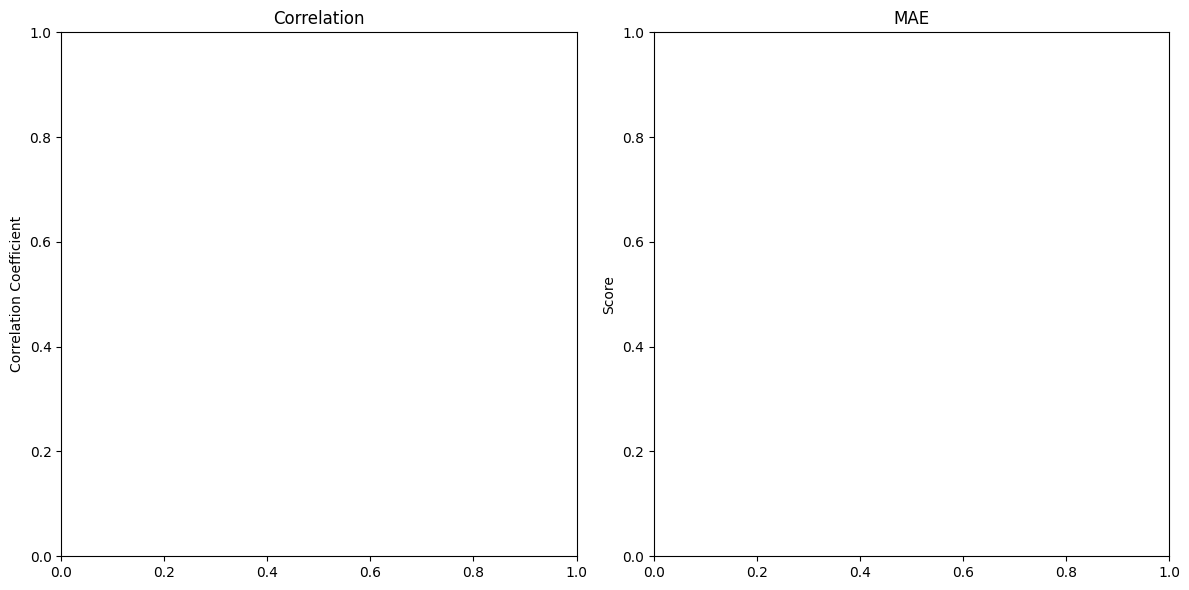

In [32]:
models = ['LSTM', 'SD-LSTM', 'VAE', 'SD-VAE']
metrics_data = {
    'Correlation': {
        # 'LSTM': lstm_p_metrics[0][0],
        # 'SD-LSTM': sd_lstm_p_metrics[0][0],
        # 'VAE': vae_p_metrics[0][0],
        # 'SD-VAE': sd_vae_p_metrics[0][0],
        # 'REG-VAE' : reg_vae_p_metrics[0][0]
    },
    'MAE': {
        # 'LSTM': float(lstm_p_metrics[1][0]),
        # 'SD-LSTM': float(sd_lstm_p_metrics[1][0]),
        # 'VAE': float(vae_p_metrics[1][0]),
        # 'SD-VAE': float(sd_vae_p_metrics[1][0]),
        # 'REG-VAE' : float(reg_vae_p_metrics[1][0])
    }
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

for ax, (metric, values) in zip(axes, metrics_data.items()):
    sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
    ax.set_title(metric)
    ax.set_ylabel('Score' if metric == 'MAE' else 'Correlation Coefficient')
    ax.set_ylim(0, 1 if metric == 'Correlation' else None)  # Adjust the y-axis limit for correlation

plt.tight_layout()
plt.show()

## Visualise sample of smiles

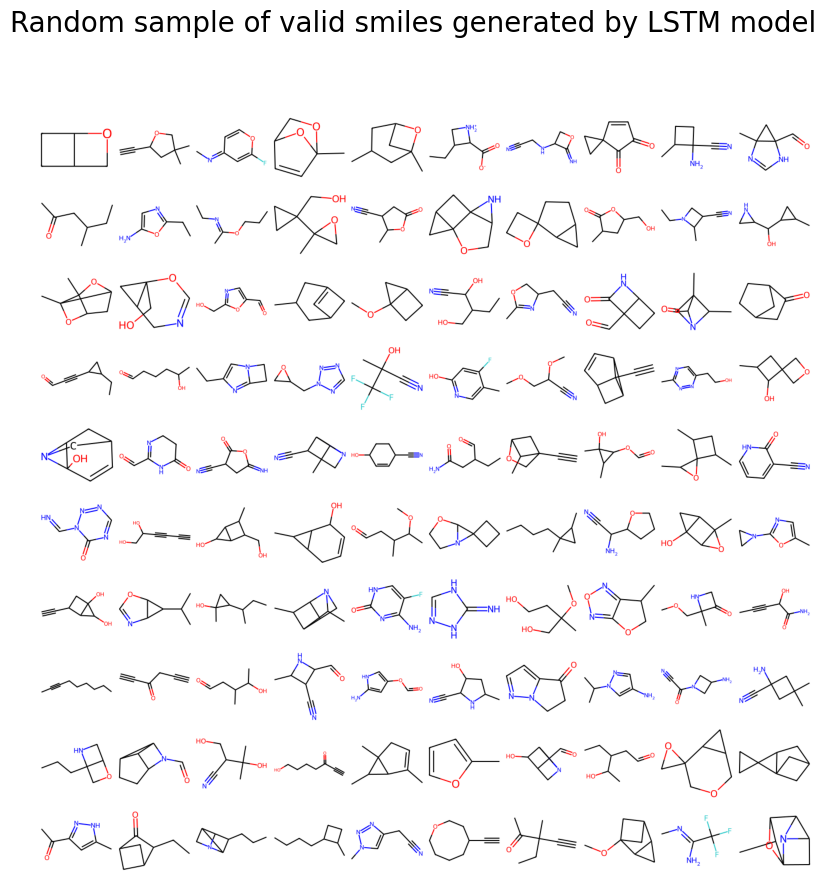

In [28]:
plot_smiles(lstm_global_sample_smiles, title="Random sample of valid smiles generated by LSTM model")

In [49]:
plot_smiles(sd_lstm_global_sample_smiles, title="Random sample of valid smiles generated by SD-LSTM model")


NameError: name 'sd_lstm_global_sample_smiles' is not defined

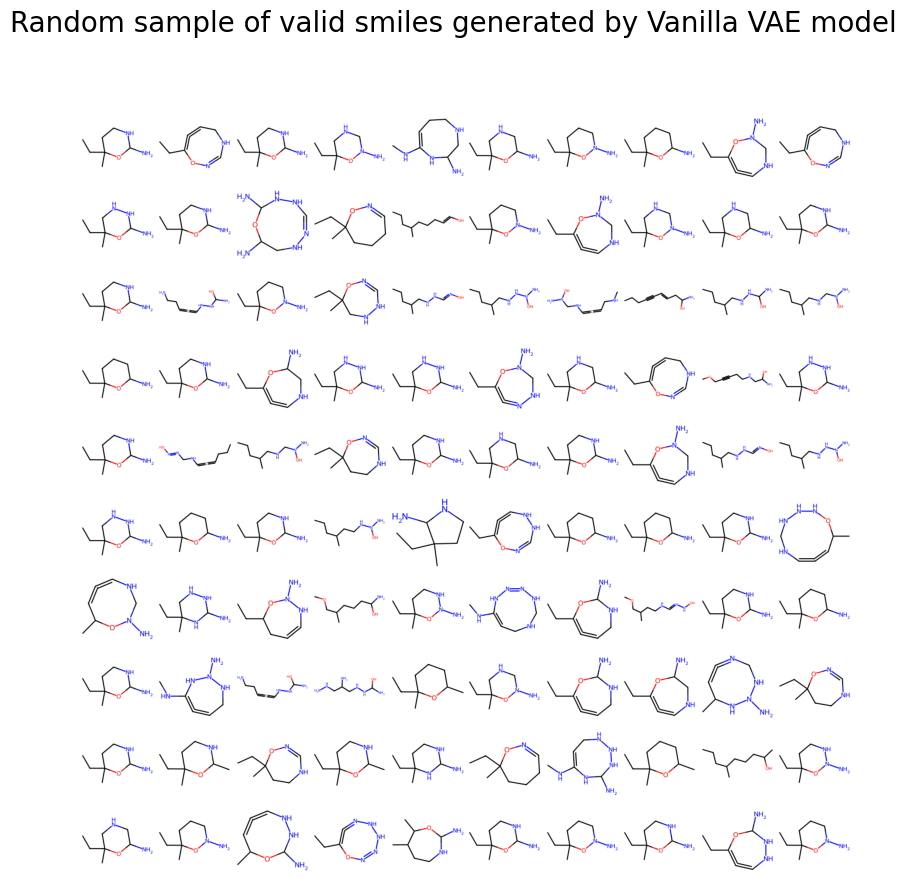

In [39]:
plot_smiles(vae_global_sample_smiles, title="Random sample of valid smiles generated by Vanilla VAE model")


In [51]:
plot_smiles(sd_vae_global_sample_smiles, title="Random sample of valid smiles generated by SD VAE model")

NameError: name 'sd_vae_global_sample_smiles' is not defined

In [37]:
plot_smiles(reg_vae_global_sample_smiles, title="Random sample of valid smiles generated by Regularized VAE model")

AssertionError: 

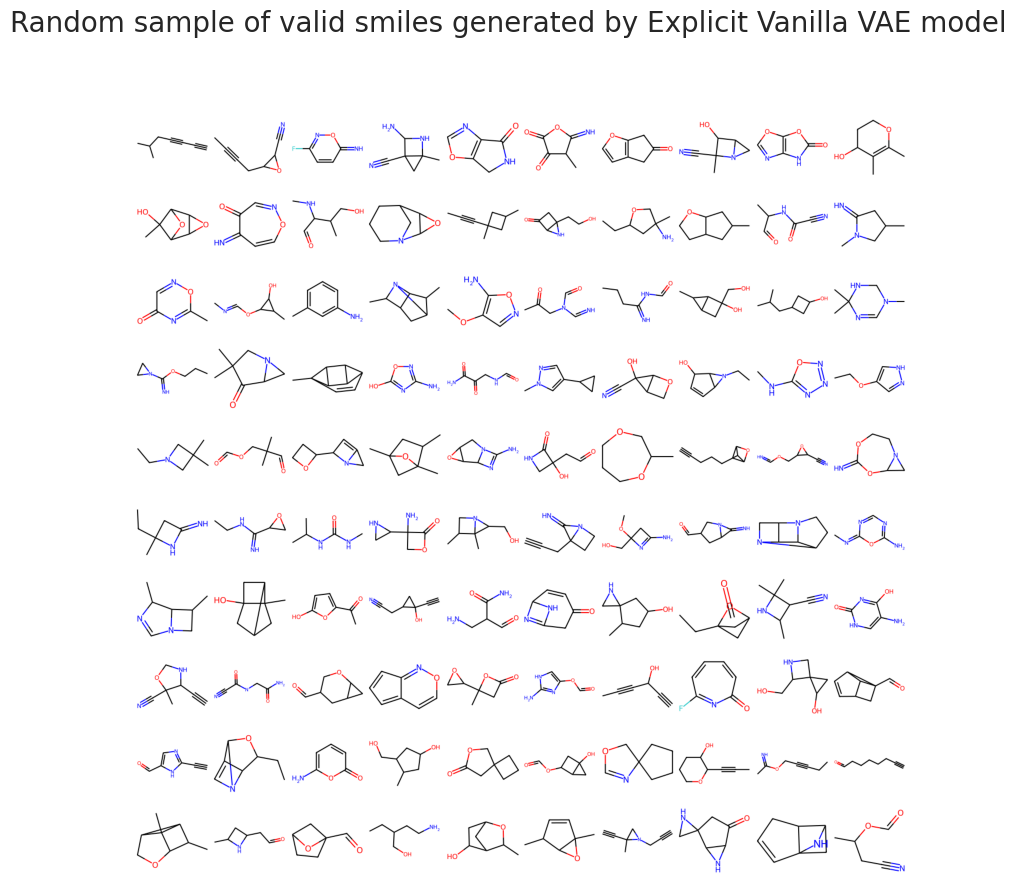

In [33]:
plot_smiles(explicit_vae_global_sample_smiles, title="Random sample of valid smiles generated by Explicit Vanilla VAE model")

# Performance as a Funct. of Target Value

In [34]:
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

In [37]:
model_sampler = explicit_vae_sampler
model_model = explicit_vae_model

In [39]:
# Now for sd_lstm
model_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'novelty':[]
    }

model_steps_properties = []
model_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

model_steps_properties = []

for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = model_sampler.sample(model=model_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=101)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    try:
        valid, uniq, novel = amina_metrics(smiles, props)
    except ZeroDivisionError:
        valid = 0.0
        uniq = 0.0
        novel = 0.0

    model_pstep_smiles['validity'].append(valid)
    model_pstep_smiles['unique_pct'].append(uniq)
    model_pstep_smiles['novelty'].append(novel)
    

    model_steps_properties.append(properties)
    model_steps_stats['Failed to decode'].append(missing)
    model_steps_stats['Invalid Smiles'].append(invalid)
    model_steps_stats['Valid'].append(samp_per_step - missing - invalid)



  0%|          | 0/12 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 12/12 [00:53<00:00,  4.48s/it]


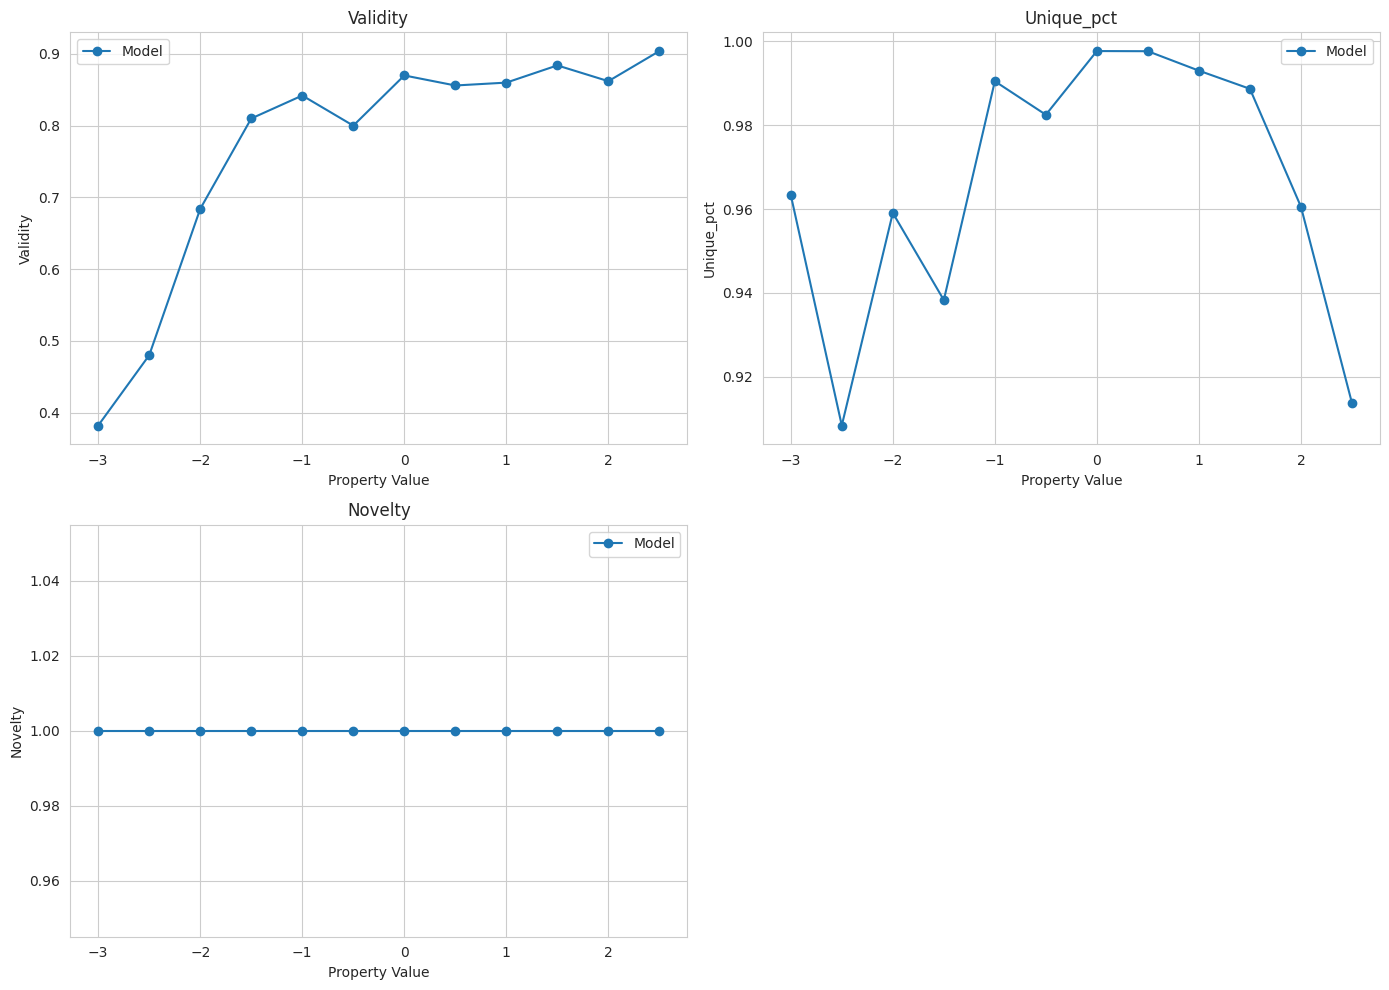

In [40]:
# Assume we have properties for both models in sd_lstm_pstep_smiles and lstm_pstep_smiles
keys = ['validity', 'unique_pct', 'novelty']

plt.figure(figsize=(14, 10))

for i, key in enumerate(keys, 1):
    plt.subplot(2, 2, i)
    plt.plot(property_steps, model_pstep_smiles[key], label='Model', marker='o', linestyle='-')

    plt.title(key.capitalize())
    plt.xlabel('Property Value')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

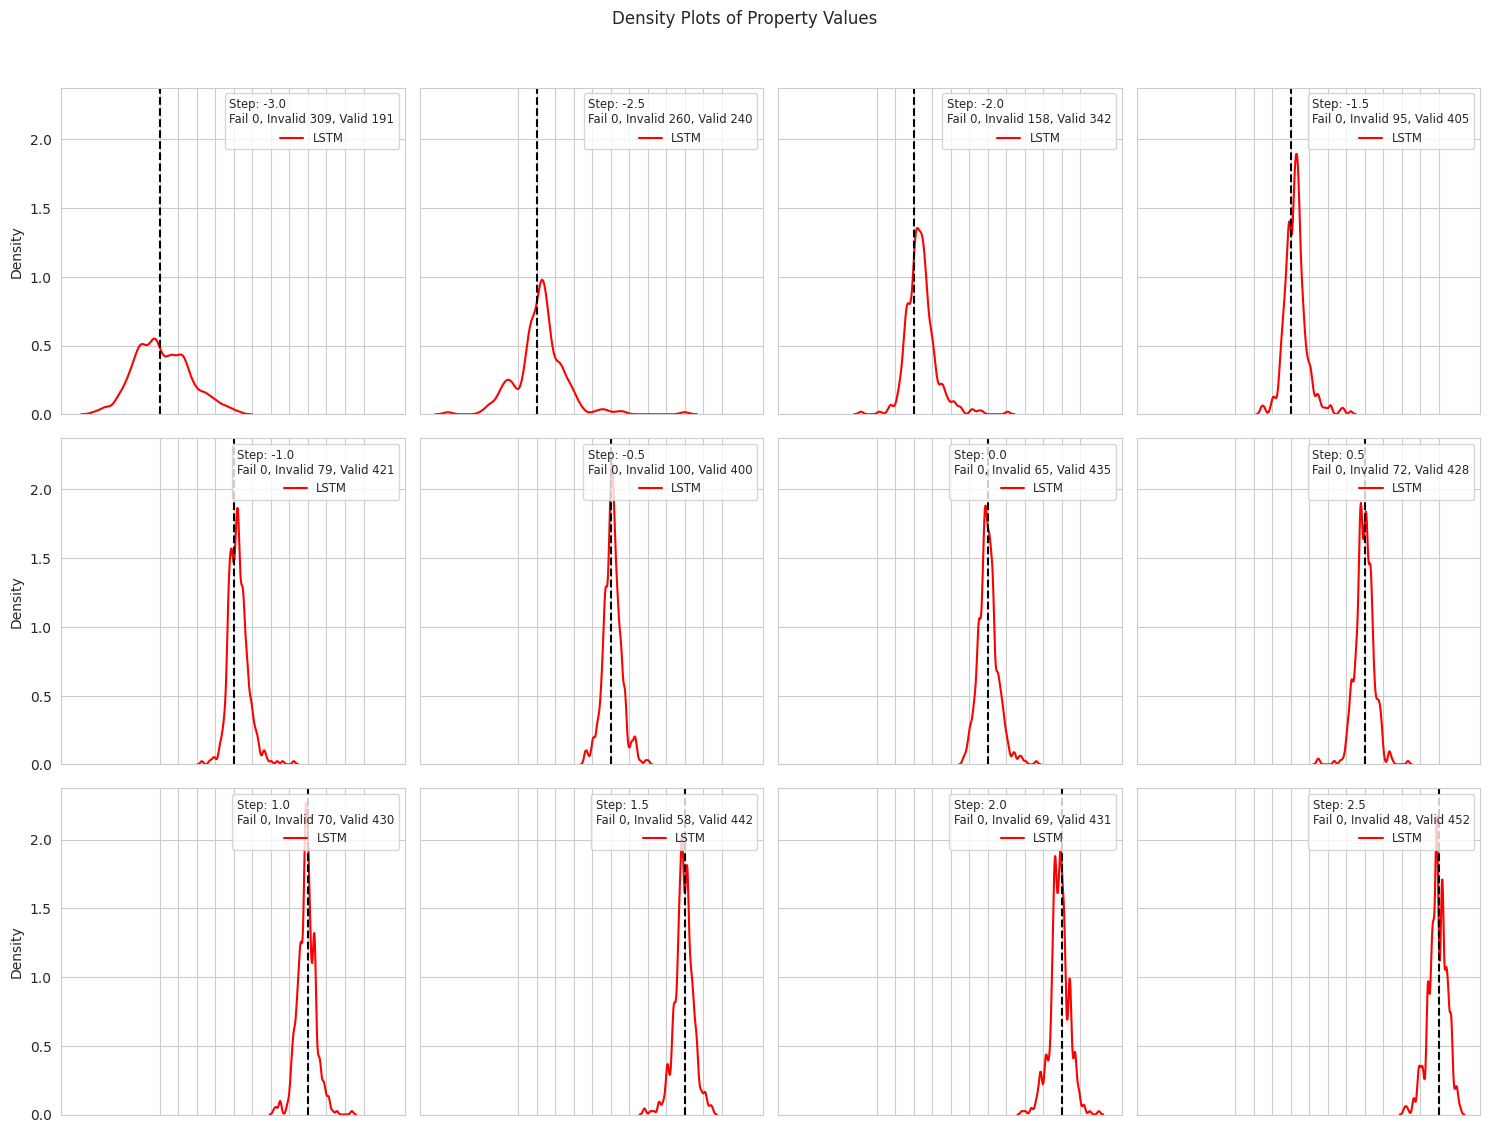

In [41]:

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    
    if model_steps_properties[i]:
        sns.kdeplot(model_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)

    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--')

    ax.set_xticks(property_steps)

    # Adding legend with dynamic title
    ax.legend(title=f'Step: {p_val}\nFail {model_steps_stats["Failed to decode"][i]}, Invalid {model_steps_stats["Invalid Smiles"][i]}, Valid {model_steps_stats["Valid"][i]}',
              loc='upper right', fontsize='small', title_fontsize='small')

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, 16):
    fig.delaxes(axes_flat[j])

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()

NameError: name 'vae_steps_properties' is not defined

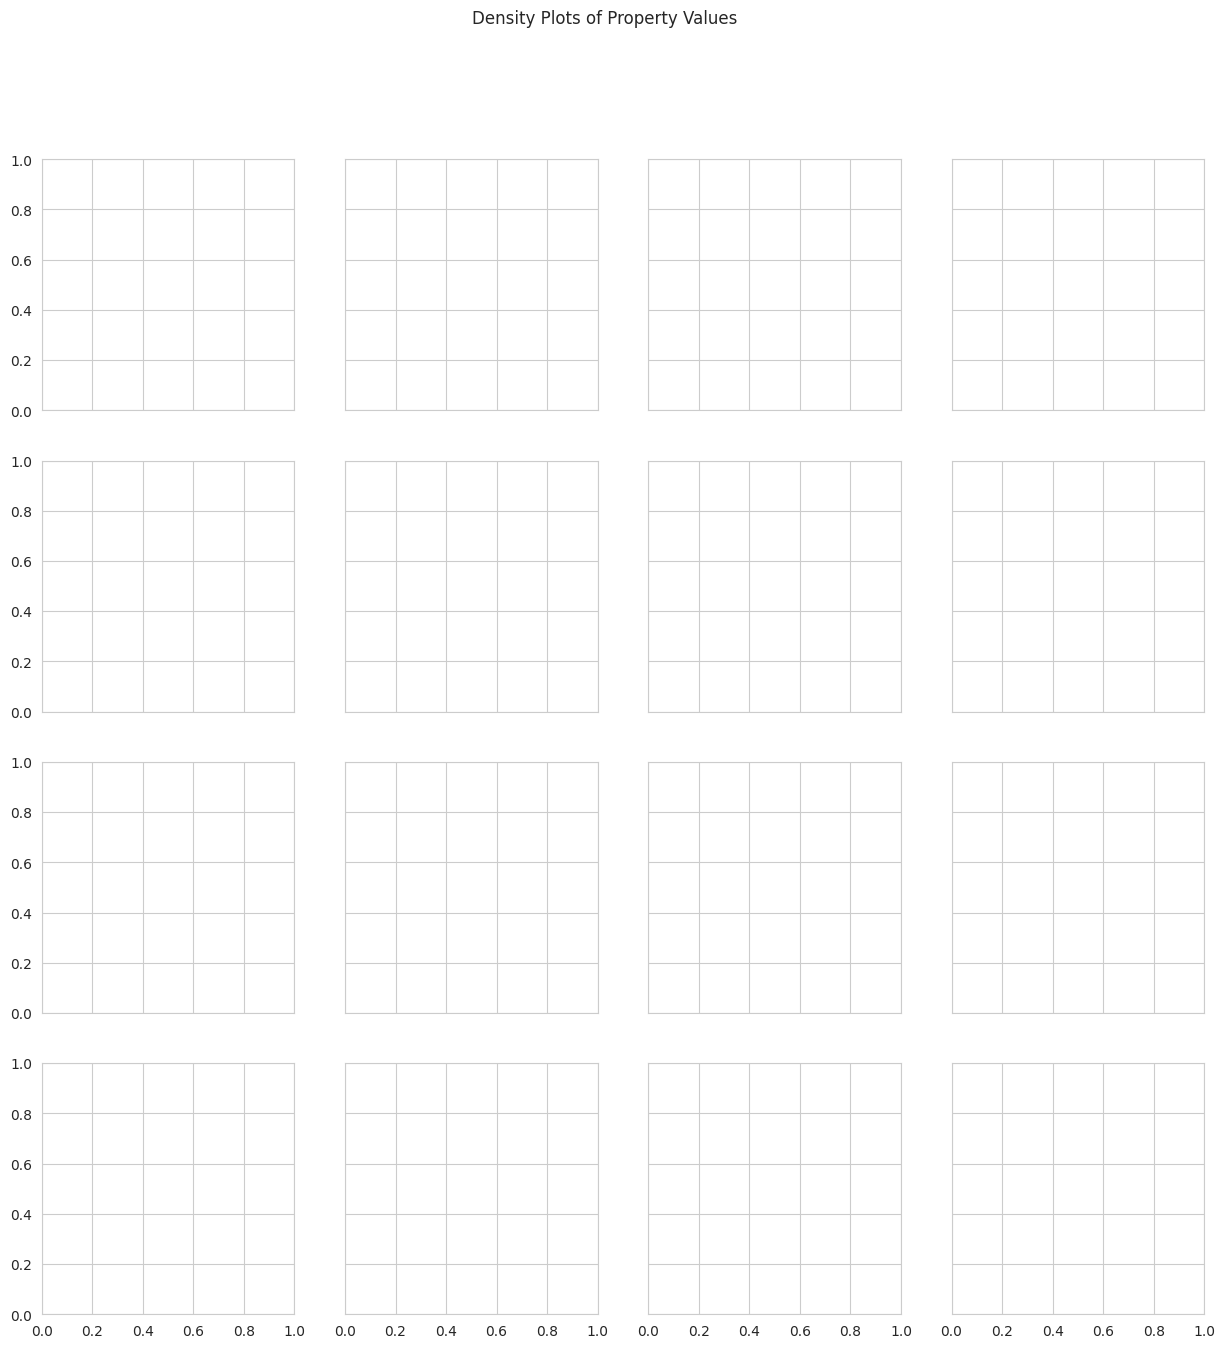

In [42]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    

    if vae_steps_properties[i]:
        sns.kdeplot(vae_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)


    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--', label=f'Target: {p_val}')

    # Define these values as per your data range and desired step
    ax.set_xticks(property_ticks)
    
    # Adding legend
    ax.legend(title=f'Step: {p_val}', loc='upper right', fontsize='small', title_fontsize='small', 
              labels=[
                  f' Fail {vae_steps_stats["Failed to decode"][i]}, Invalid {vae_steps_stats["Invalid Smiles"][i]}, Valid {vae_steps_stats["Valid"][i]}',
                  f'Target: {p_val}'
              ])

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()